# Q2 Customer Segmentation 

### Load the Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


## Data Loading

In [3]:
df= pd.read_csv("customer_behavior_analytcis.csv")

## Exploratory Data Analysis (EDA)

In [4]:
# print the first 5 rows of the data
df.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id
0,7.0,129.34,52.17,18.0,0.0,CM00000
1,22.0,24.18,9.19,15.0,7.0,CM00001
2,2.0,32.18,90.69,50.0,2.0,CM00002
3,25.0,26.85,11.22,16.0,10.0,CM00003
4,7.0,125.45,34.19,30.0,3.0,CM00004


In [5]:
# print the shape of the dateset
df.shape  

(999, 6)

In [6]:
# check the columns of the dataframe
df.columns

Index(['total_purchases', 'avg_cart_value', 'total_time_spent',
       'product_click', 'discount_counts', 'customer_id'],
      dtype='object')

In [7]:
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_purchases   979 non-null    float64
 1   avg_cart_value    979 non-null    float64
 2   total_time_spent  999 non-null    float64
 3   product_click     979 non-null    float64
 4   discount_counts   999 non-null    float64
 5   customer_id       999 non-null    object 
dtypes: float64(5), object(1)
memory usage: 47.0+ KB


In [8]:
# description of the data
df.describe()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
count,979.000000,979.000000,999.000000,979.000000,999.000000
mean,11.570991,75.457978,49.348759,28.237998,4.313313
std,7.016327,55.067835,32.730973,16.296384,4.532772
min,0.000000,10.260000,5.120000,4.000000,0.000000
25%,6.000000,33.130000,22.375000,16.000000,1.000000
50%,10.000000,49.380000,40.360000,21.000000,2.000000
75%,17.000000,121.255000,77.170000,45.000000,8.000000
max,32.000000,199.770000,119.820000,73.000000,21.000000


In [9]:
# check for missing values
df.isnull().sum()

total_purchases     20
avg_cart_value      20
total_time_spent     0
product_click       20
discount_counts      0
customer_id          0
dtype: int64

<Axes: >

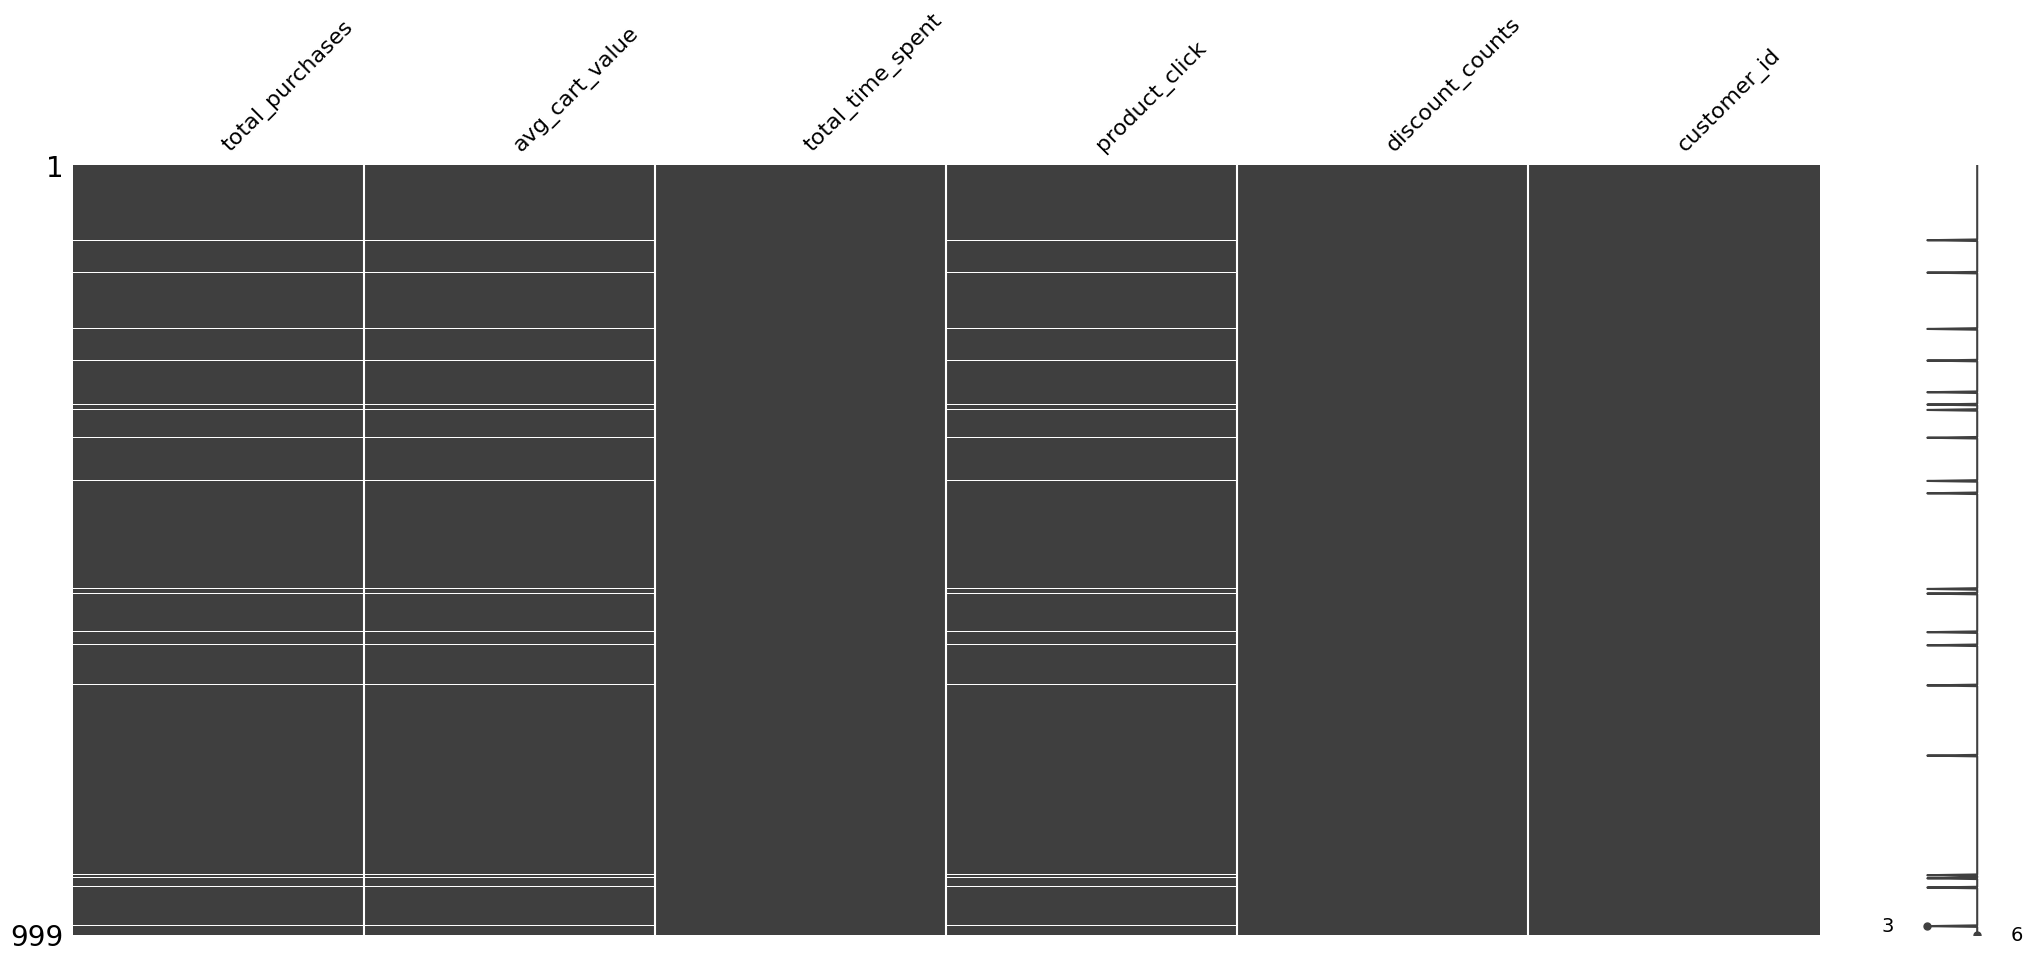

In [10]:
# visualize the missing values
msno.matrix(df)

c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

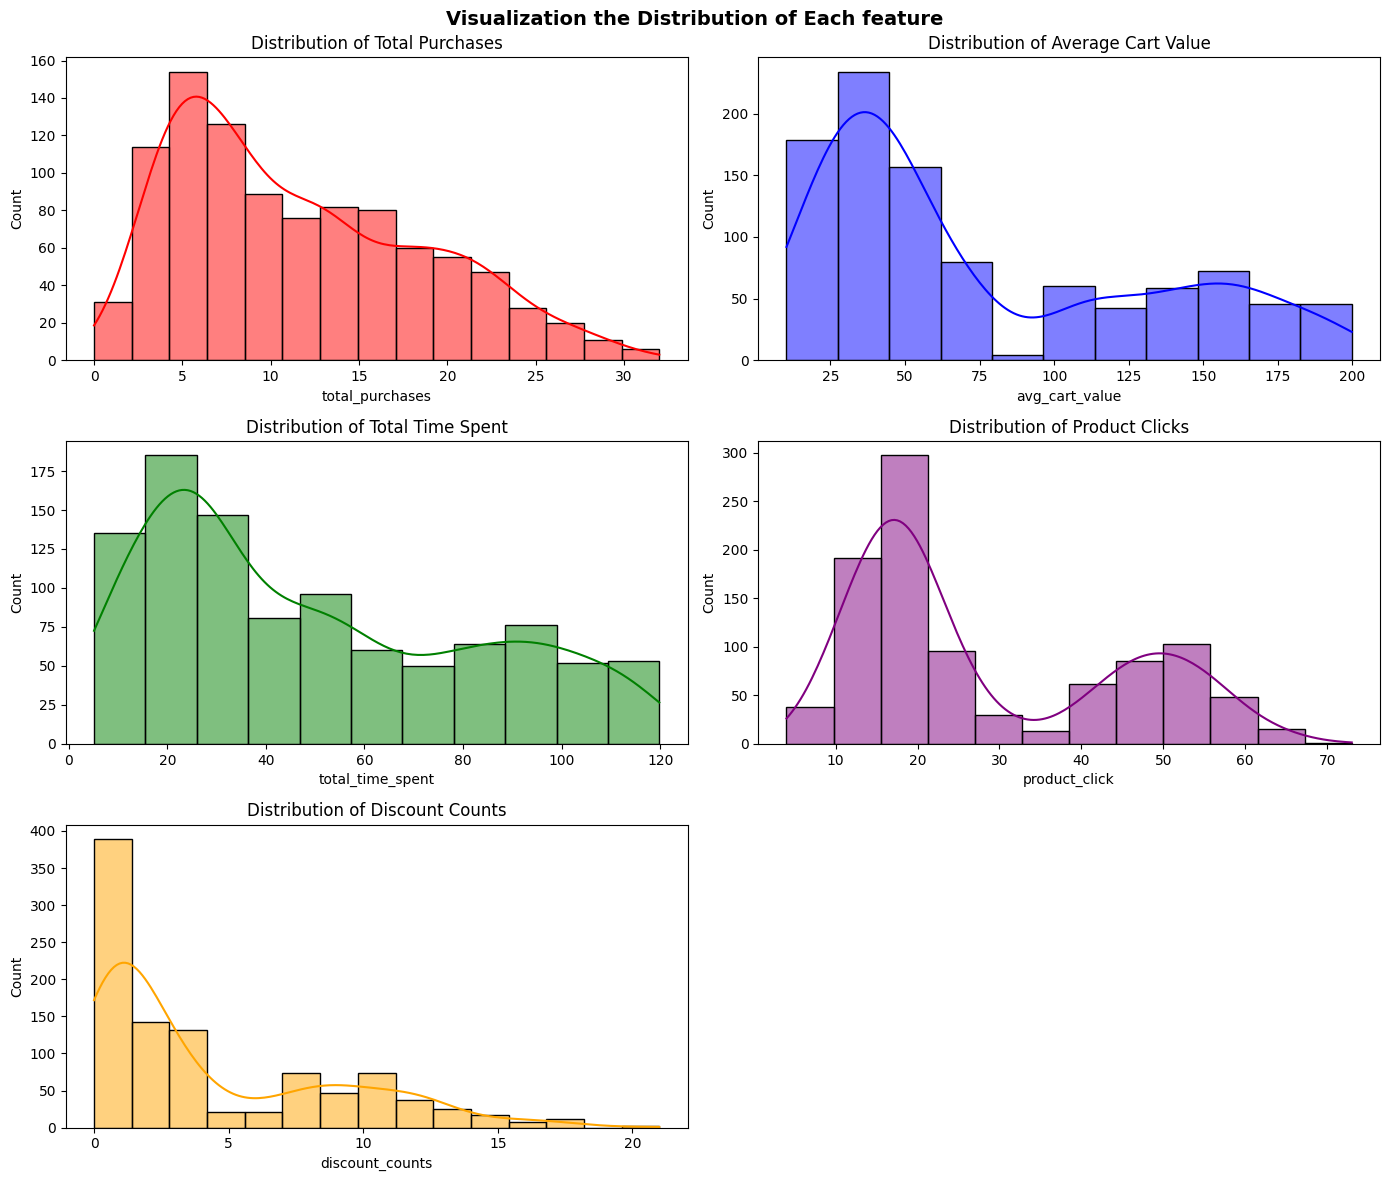

In [11]:
plt.figure(figsize=(14, 12))

plt.suptitle('Visualization the Distribution of Each feature', fontsize=14, fontweight='bold')
# First row
plt.subplot(3, 2, 1)
sns.histplot(df, x='total_purchases', color='red', kde=True)
plt.title('Distribution of Total Purchases')

plt.subplot(3, 2, 2)
sns.histplot(df, x='avg_cart_value', color='blue', kde=True)
plt.title('Distribution of Average Cart Value')

# Second row
plt.subplot(3, 2, 3)
sns.histplot(df, x='total_time_spent', color='green', kde=True)
plt.title('Distribution of Total Time Spent')

plt.subplot(3, 2, 4)
sns.histplot(df, x='product_click', color='purple', kde=True)
plt.title('Distribution of Product Clicks')

# Third row (only one plot)
plt.subplot(3, 2, 5)
sns.histplot(df, x='discount_counts', color='orange', kde=True)
plt.title('Distribution of Discount Counts')

# Adjust layout
plt.tight_layout()
plt.show()


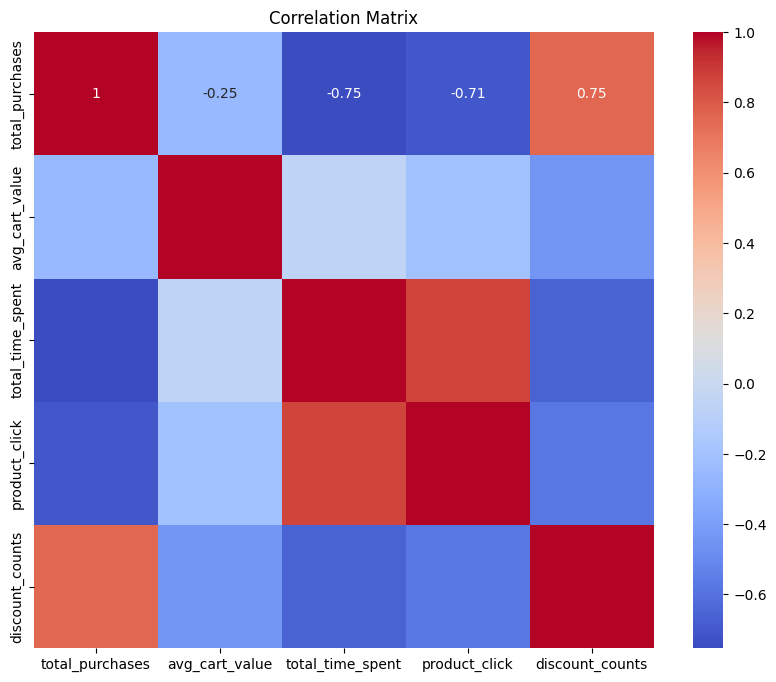

In [12]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop('customer_id', axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Data Preprocessing

In [13]:
# Separate features and identifiers
customer_ids = df['customer_id']
X = df.drop('customer_id', axis=1)

# Impute missing values using KNN
imputer = KNNImputer(n_neighbors=5)  # Uses 5 most similar customers
X_imputed = imputer.fit_transform(X)

# Reconstruct DataFrame
df_imputed = pd.DataFrame(X_imputed, columns=X.columns)
df_imputed['customer_id'] = customer_ids

In [14]:
# Check for missing values
df_imputed.isnull().sum()

total_purchases     0
avg_cart_value      0
total_time_spent    0
product_click       0
discount_counts     0
customer_id         0
dtype: int64

In [15]:
# Outliers Detection using the IQR method
outliers = {}
for column in ['total_purchases', 'avg_cart_value', 'total_time_spent','product_click','discount_counts']:
    Q1 = df_imputed[column].quantile(0.25)
    Q3 = df_imputed[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[column] = df_imputed[(df_imputed[column] < lower_bound) | (df_imputed[column] > upper_bound)]

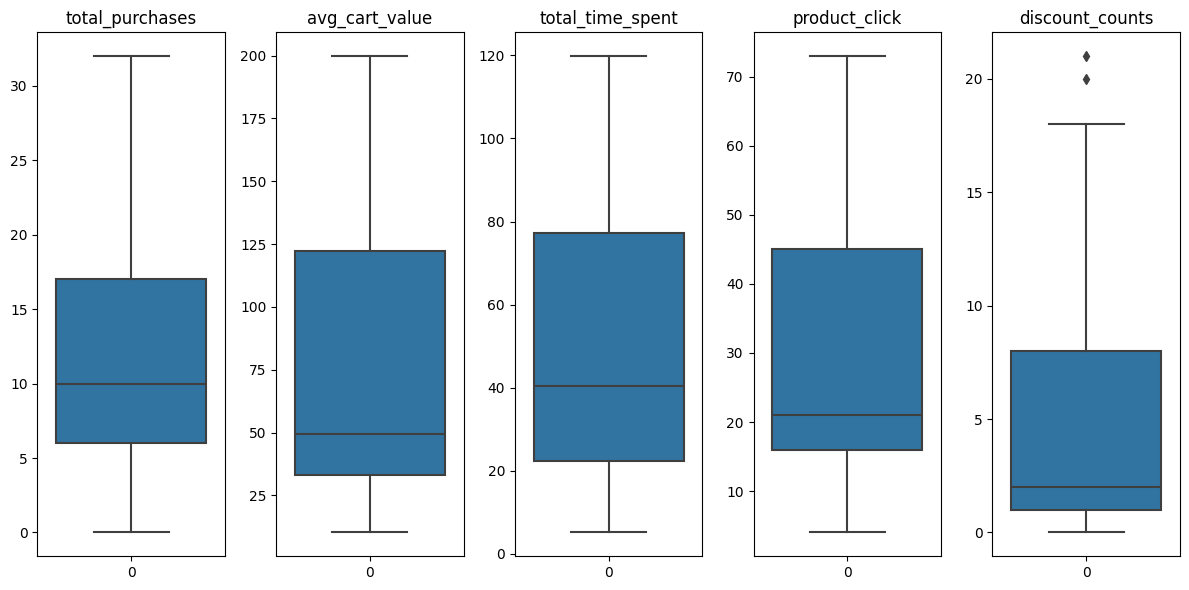

In [16]:
# Visualize outliers using box plots
plt.figure(figsize=(12, 6))
for i, column in enumerate(['total_purchases', 'avg_cart_value', 'total_time_spent','product_click','discount_counts']):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(df_imputed[column])
    plt.title(column)
plt.tight_layout()
plt.show()

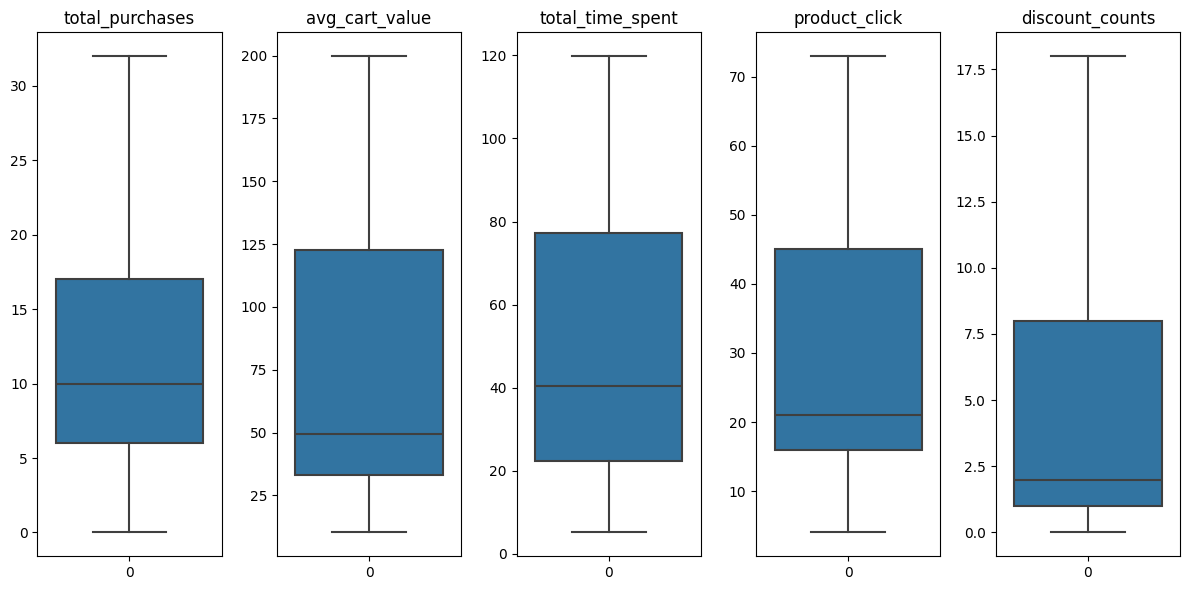

In [17]:
# Removing outliers using the IQR method
for column in ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']:
    Q1 = df_imputed[column].quantile(0.25)
    Q3 = df_imputed[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    df_imputed = df_imputed[(df_imputed[column] >= lower_bound) & (df_imputed[column] <= upper_bound)]

# Visualize the distribution of the data after removing outliers
plt.figure(figsize=(12, 6))
for i, column in enumerate(['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(df_imputed[column])
    plt.title(column)
    plt.tight_layout()
plt.show()


In [18]:
df_imputed.shape

(997, 6)

In [19]:
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed.drop('customer_id', axis=1))

### Model Selection

In [20]:
inertia = []
silhouettes = []
k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory 

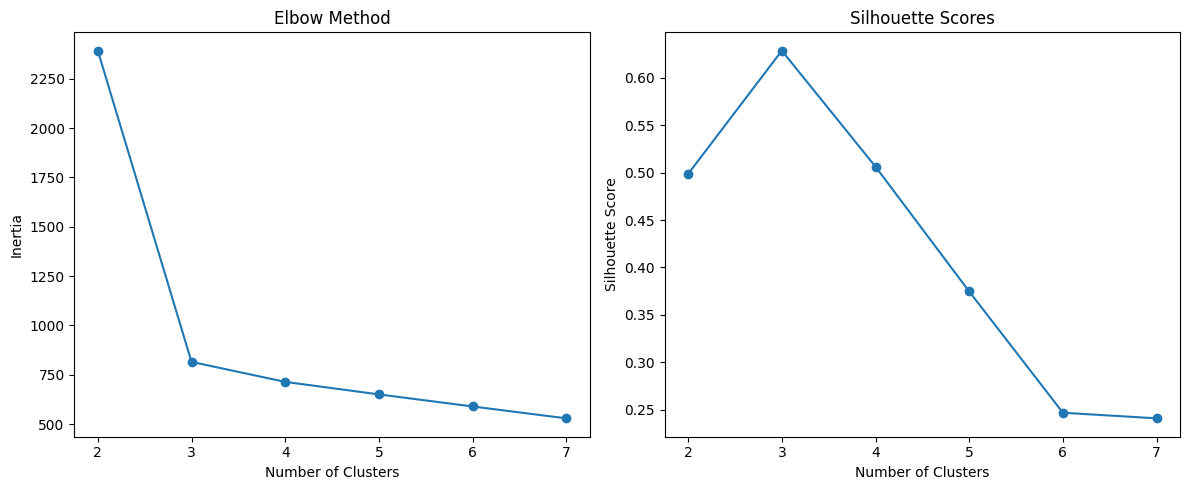

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [22]:
# Using KMeans to cluster the data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df_imputed['Cluster'] = clusters

c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [23]:
# Create new DataFrame to use Agglomerative Clustering
df_new = df_imputed.copy()

In [24]:
X_scaled1 = scaler.fit_transform(df_new.drop('customer_id', axis=1))

# Using Agglomerative Clustering to cluster the data
model = AgglomerativeClustering(n_clusters=3, linkage='ward')  # Use Euclidean distance
clusters = model.fit_predict(X_scaled1)
df_new['Cluster'] = clusters


In [25]:
# check the dataset 
df_new.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id,Cluster
0,7.0,129.34,52.17,18.0,0.0,CM00000,1
1,22.0,24.18,9.19,15.0,7.0,CM00001,0
2,2.0,32.18,90.69,50.0,2.0,CM00002,2
3,25.0,26.85,11.22,16.0,10.0,CM00003,0
4,7.0,125.45,34.19,30.0,3.0,CM00004,1


In [26]:
# check what are the values in cluster column
df_imputed['Cluster'].value_counts()

Cluster
0    333
1    333
2    331
Name: count, dtype: int64

In [27]:
df_new['Cluster'].value_counts()

Cluster
1    333
2    333
0    331
Name: count, dtype: int64

### Model Evaluation

In [28]:
print(f'Silhouette Score for Kmean Cluster: {silhouette_score(X_scaled, clusters):.3f}')

Silhouette Score for Kmean Cluster: 0.629


In [29]:
print(f'Silhouette Score for AgglomerativeClustering: {silhouette_score(X_scaled1, clusters):.3f}')

Silhouette Score for AgglomerativeClustering: 0.677


In [30]:
# KMeans Clustering
kmeans_clusters = kmeans.fit_predict(X_scaled)
print("KMeans Metrics:")
print(f"Silhouette Score: {silhouette_score(X_scaled, kmeans_clusters)}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled, kmeans_clusters)}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, kmeans_clusters)}")

# AgglomerativeClustering
agglomerative_clusters = model.fit_predict(X_scaled1)
print("\nAgglomerativeClustering Metrics:")
print(f"Silhouette Score: {silhouette_score(X_scaled1, agglomerative_clusters)}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled1, agglomerative_clusters)}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled1, agglomerative_clusters)}")


KMeans Metrics:
Silhouette Score: 0.6285705347937766
Calinski-Harabasz Index: 2543.104860107451


c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DELL\.conda\envs\condaenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Davies-Bouldin Index: 0.5447498619122977

AgglomerativeClustering Metrics:
Silhouette Score: 0.6766538208644823
Calinski-Harabasz Index: 3151.125832128937
Davies-Bouldin Index: 0.4674517039672552


In [31]:
# Dimensionality Reduction for KMeans
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_imputed['PCA1'] = X_pca[:, 0]
df_imputed['PCA2'] = X_pca[:, 1]

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
df_imputed['TSNE1'] = X_tsne[:, 0]
df_imputed['TSNE2'] = X_tsne[:, 1]

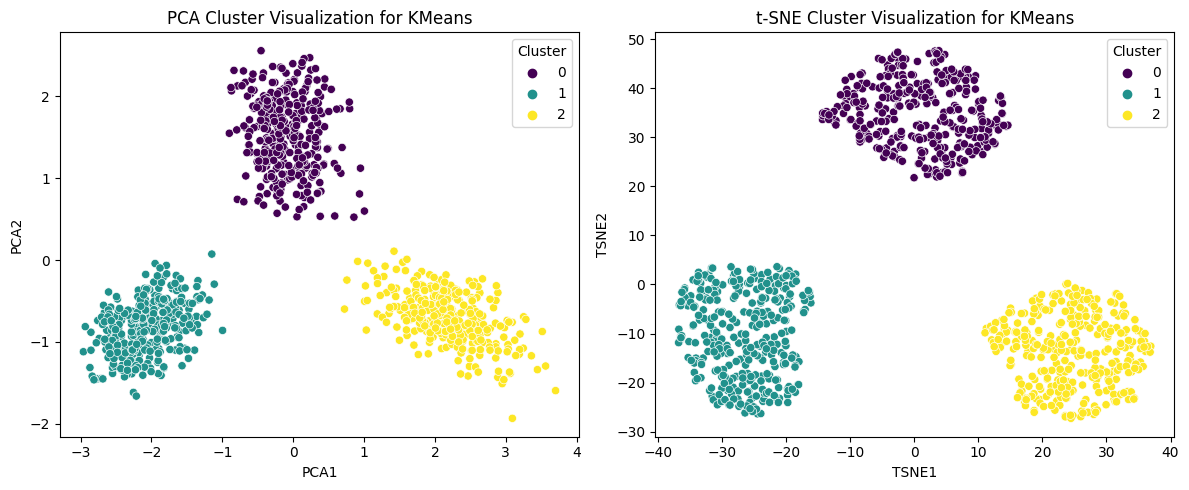

In [32]:
# Plot clusters in PCA and t-SNE space for KMeans
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_imputed, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('PCA Cluster Visualization for KMeans')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_imputed, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis')
plt.title('t-SNE Cluster Visualization for KMeans')
plt.tight_layout()
plt.show()

In [33]:
# Dimensionality Reduction for Agglomerative Clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled1)
df_new['PCA1'] = X_pca[:, 0]
df_new['PCA2'] = X_pca[:, 1]

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled1)
df_new['TSNE1'] = X_tsne[:, 0]
df_new['TSNE2'] = X_tsne[:, 1]

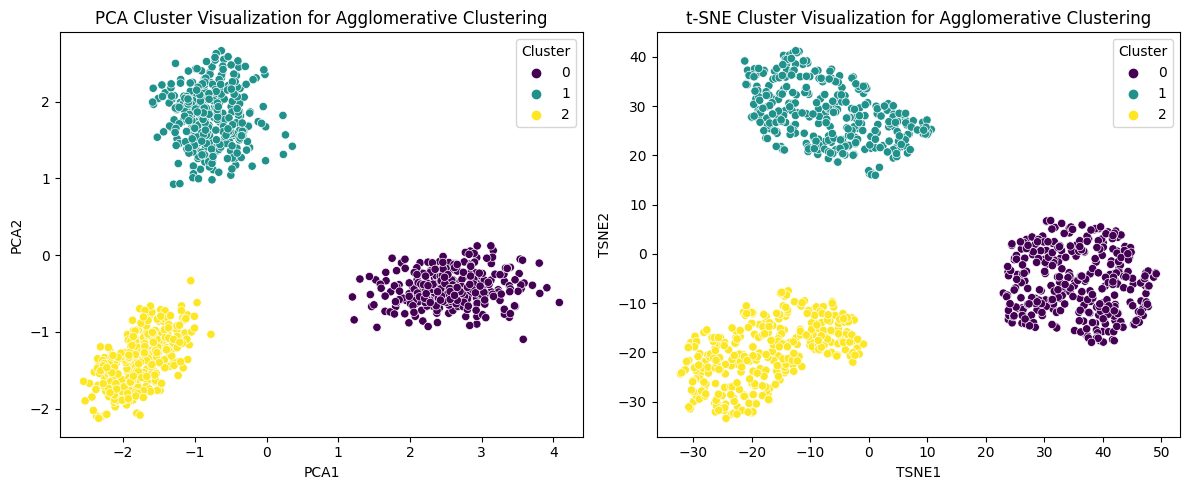

In [34]:
# Plot clusters in PCA and t-SNE space for Agglomerative Clustering
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_new, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('PCA Cluster Visualization for Agglomerative Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_new, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis')
plt.title('t-SNE Cluster Visualization for Agglomerative Clustering')
plt.tight_layout()
plt.show()

In [35]:
# check the dataset
df_imputed.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id,Cluster,PCA1,PCA2,TSNE1,TSNE2
0,7.0,129.34,52.17,18.0,0.0,CM00000,0,-0.626337,1.403022,2.352121,22.490849
1,22.0,24.18,9.19,15.0,7.0,CM00001,2,2.170888,-0.570380,25.347961,-3.490820
2,2.0,32.18,90.69,50.0,2.0,CM00002,1,-2.163601,-1.123570,-26.422472,-10.556408
3,25.0,26.85,11.22,16.0,10.0,CM00003,2,2.646433,-0.824608,32.788605,-9.808866
4,7.0,125.45,34.19,30.0,3.0,CM00004,0,-0.374936,0.984695,-2.070517,30.137058


In [36]:
# Define numeric features
numeric_features = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']

# Calculate cluster means for numeric features only
cluster_profile = df_imputed.groupby('Cluster')[numeric_features].mean()
cluster_profile

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
Cluster,,,,,
0,10.177177,147.229405,40.389730,19.903303,1.945946
1,4.860661,49.064583,90.144865,49.737538,1.024024
2,19.700906,30.466308,17.466858,14.981269,9.906344


In [37]:

# Calculate cluster means for numeric features only
cluster_profile1 = df_new.groupby('Cluster')[numeric_features].mean()
cluster_profile1

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
Cluster,,,,,
0,19.700906,30.466308,17.466858,14.981269,9.906344
1,10.177177,147.229405,40.389730,19.903303,1.945946
2,4.860661,49.064583,90.144865,49.737538,1.024024


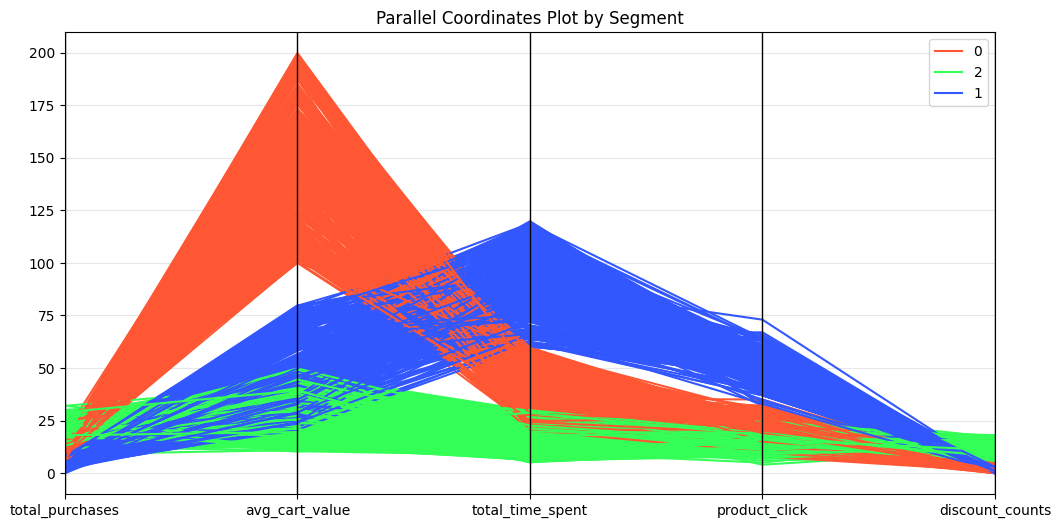

In [38]:
# Parallel Coordinates Plot
plt.figure(figsize=(12, 6))
features = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']
pd.plotting.parallel_coordinates(df_imputed, 'Cluster', features, color=('#FF5733', '#33FF57', '#3357FF'))
plt.title('Parallel Coordinates Plot by Segment')
plt.grid(alpha=0.3)
plt.show()

### Identifying Clusters

In [39]:
# Using KMeans to cluster the data
ranks = cluster_profile.rank(ascending=False).astype(int)


# Define segment mapping rules
segment_map = {}
for cluster in ranks.index:
    if (ranks.loc[cluster, 'total_purchases'] == 1 and 
        ranks.loc[cluster, 'discount_counts'] == 1 and 
        ranks.loc[cluster, 'avg_cart_value'] == 3):
        segment_map[cluster] = "Bargain Hunters"
    elif (ranks.loc[cluster, 'avg_cart_value'] == 1 and 
          ranks.loc[cluster, 'discount_counts'] >=2):
        segment_map[cluster] = "High Spenders"
    elif (ranks.loc[cluster, 'total_time_spent'] == 1 and 
          ranks.loc[cluster, 'product_click'] == 1 and 
          ranks.loc[cluster, 'total_purchases'] == 3):
        segment_map[cluster] = "Window Shoppers"

# Assign segments to both profile and original data
cluster_profile['Segment'] = cluster_profile.index.map(segment_map)
df_imputed['Segment'] = df_imputed['Cluster'].map(segment_map)

print("Automatically Labeled Clusters:")
cluster_profile

Automatically Labeled Clusters:


,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,Segment
Cluster,,,,,,
0,10.177177,147.229405,40.389730,19.903303,1.945946,High Spenders
1,4.860661,49.064583,90.144865,49.737538,1.024024,Window Shoppers
2,19.700906,30.466308,17.466858,14.981269,9.906344,Bargain Hunters


In [40]:
# Use Agglomerative Clustering to cluster the data

ranks1 = cluster_profile1.rank(ascending=False).astype(int)

# Define segment mapping rules
segment_map1 = {}
for cluster in ranks1.index:
    if (ranks1.loc[cluster, 'total_purchases'] == 1 and 
        ranks1.loc[cluster, 'discount_counts'] == 1 and 
        ranks1.loc[cluster, 'avg_cart_value'] == 3):
        segment_map1[cluster] = "Bargain Hunters"
    elif (ranks1.loc[cluster, 'avg_cart_value'] == 1 and 
          ranks1.loc[cluster, 'discount_counts'] >= 2):
        segment_map1[cluster] = "High Spenders"
    elif (ranks1.loc[cluster, 'total_time_spent'] == 1 and 
          ranks1.loc[cluster, 'product_click'] == 1 and 
          ranks1.loc[cluster, 'total_purchases'] == 3):
        segment_map1[cluster] = "Window Shoppers"

# Assign segments to both profile and original data
cluster_profile1['Segment'] = cluster_profile1.index.map(segment_map1)
df_new['Segment'] = df_new['Cluster'].map(segment_map1)

print("Automatically Labeled Clusters:")
cluster_profile1


Automatically Labeled Clusters:


,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,Segment
Cluster,,,,,,
0,19.700906,30.466308,17.466858,14.981269,9.906344,Bargain Hunters
1,10.177177,147.229405,40.389730,19.903303,1.945946,High Spenders
2,4.860661,49.064583,90.144865,49.737538,1.024024,Window Shoppers
